In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
%matplotlib inline 
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:

        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/who-tweeted-that/modified.csv
/kaggle/input/who-tweeted-that/test_tweets_unlabeled.txt/test_tweets_unlabeled.txt


In [2]:
TRAINSET_PATH = '/kaggle/input/who-tweeted-that/modified.csv'
TEST_SET_PATH = '/kaggle/input/who-tweeted-that/test_tweets_unlabeled.txt/test_tweets_unlabeled.txt'
df = pd.read_csv(TRAINSET_PATH, encoding="utf-8")
x_test_df = pd.read_csv(TEST_SET_PATH, sep='\n', encoding="utf-8", quoting=3, names=["tweet"])
print(df.shape)
print(x_test_df.shape)

(328932, 2)
(35437, 1)


In [3]:
# Cast the type of User_id field from int to string 
df.user_id = df.user_id.apply(str)
df.user_id.value_counts()

4185    284
5519    273
319     273
4267    265
4562    264
       ... 
3783      1
3537      1
8180      1
9294      1
4352      1
Name: user_id, Length: 9297, dtype: int64

In [4]:
%%time
# IMPORTANT: Tweets Preprocessing
# Update v2 in 4 Sep: Improve the method to handle URL, RT and @handle in tweets
import re
import nltk as nlp

def pre_processing(t):
    HTTP_URL_PATTERN = r'((http|ftp|https):\/\/)?([\w-]+(?:(?:\.[\w-]{2,})+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'
    t = t.strip()
    t = re.sub(HTTP_URL_PATTERN, ' HAVELINK ', t) # Increase URL weight
    t = re.sub(r'@handle', ' ATSOMEBODY ', t) # Deal with @handle
    t = re.sub(r'^RT', ' APURERETWEET ', t)
    t = re.sub(r'RT(?!\w)', ' WITHARETWEET ', t)
    
    # Find hashtag and emphasize it
    m = re.search(r'#(?P<hashtag>\w+?)\b', t)
    while m is not None:
        hashtag = m.group('hashtag')
        t = re.sub(r'#'+hashtag, (' '+hashtag+' ')*3, t)
        m = re.search(r'#(?P<hashtag>\w+?)\b', t)
    
    t = re.sub('\s\W',' ',t)
    t = re.sub('\W,\s',' ',t)
    t = re.sub(r'\W', ' ', t)
    t = re.sub("\d+", " ", t)
    t = re.sub('\s+',' ',t)
    t = re.sub('[!@#$_]', ' ', t)
    t = t.lower()

    lemma = nlp.WordNetLemmatizer()
    stemmed_tweet = ""
    for word in t.split():
        stemmed_tweet += lemma.lemmatize(word)
        stemmed_tweet += " "
    return stemmed_tweet.strip()

df.tweet = df.tweet.apply(pre_processing)
x_test_df.tweet = x_test_df.tweet.apply(pre_processing)

CPU times: user 53.1 s, sys: 908 ms, total: 54 s
Wall time: 54.8 s


In [ ]:
# x_test_df.tweet.apply(str)
# try:
#     mistake=""
#     count=0
#     for tweet in x_test_df.tweet:
#         mistake = tweet
#         pre_processing(tweet)
#         count += 1
# except:
#     print(mistake)
#     print(count)

In [5]:
# remove non important words such as 'a', 'the', 'that' 
# nlp.download("stopwords")  # stopwords = (irrelavent words)
from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))

In [6]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
ALL_TWEETS = df.tweet.tolist() + x_test_df.tweet.tolist()
# TODO: Find a way not to limit max features, or not pruning according to TF
vectorizer = TfidfVectorizer(max_features=None, max_df=0.5, ngram_range=(1, 2), lowercase=False, analyzer='word', stop_words=english_stopwords)  
X = vectorizer.fit_transform(ALL_TWEETS)
print(X.shape)
# Display All Feature(term) names
# print(vectorizer.get_feature_names()) 

(364369, 1542186)
CPU times: user 22.1 s, sys: 812 ms, total: 22.9 s
Wall time: 22.9 s


In [7]:
%%time
from sklearn.model_selection import train_test_split
x_given = X[0:df.tweet.shape[0]]
# x_test = X[df.tweet.shape[0]:]
y_given = df.user_id

RANDOM_SEED = int.from_bytes("Group95".encode(), 'little') % (2**32 - 1)
x_train, x_test, y_train, y_test = train_test_split(x_given, y_given, test_size=0.2, random_state=RANDOM_SEED)

y_train_transformed = y_train.transform(lambda x : 1 if x == '4185' else 0)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1, solver='lbfgs', max_iter=200, class_weight={1:30})
clf.fit(x_train, y_train_transformed)
# y_pred = pd.Series(clf.predict(x_test))

CPU times: user 41.5 s, sys: 26.1 s, total: 1min 7s
Wall time: 31.1 s


LogisticRegression(C=1, class_weight={1: 30}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
print(X.shape)
print(x_train.shape)
print(x_test.shape)
# print(vectorizer.get_feature_names())  Uncomment it if you want to check the specific feature(term) names

(364369, 1542186)
(263145, 1542186)
(65787, 1542186)


In [ ]:
# # Train a classfier for a specific user based on logstic regression
# from sklearn.model_selection import train_test_split
# x = X[0:df.tweet.shape[0]]
# y = df.user_id
# RANDOM_SEED = int.from_bytes("Group95".encode(), 'little') % (2**32 - 1)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)

# y_train_transformed = y_train.transform(lambda x : 1 if x == '4185' else 0)
# y_test_transformed = y_test.transform(lambda x : 1 if x == '4185' else 0)

# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(C=1, solver='lbfgs', max_iter=200, class_weight={1:30})
# clf.fit(x_train, y_train_transformed)
# y_test_pred = pd.Series(clf.predict(x_test))

# # Use F1-score to evaluate the training performance
# from sklearn.metrics import f1_score
# print(f1_score(y_test_transformed, y_test_pred, pos_label=1, average='binary'))

In [10]:
y_test_pred_proba = clf.predict_proba(x_test)[:,1]
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
y_test_transformed = y_test.transform(lambda x : 1 if x == '4185' else 0)
fpr, tpr, thresholds = roc_curve(y_test_transformed, y_test_pred_proba)
print(fpr)
print(tpr)
print(thresholds)
tpr[np.where(thresholds > 0.5)]

[0.00000000e+00 3.04316733e-05 3.04316733e-05 ... 9.96439494e-01
 9.96682948e-01 1.00000000e+00]
[0.         0.         0.01515152 ... 1.         1.         1.        ]
[1.97292297e+00 9.72922972e-01 8.88699608e-01 ... 3.50254790e-05
 1.52452547e-05 5.23541359e-07]


array([0.        , 0.        , 0.01515152, 0.01515152, 0.03030303,
       0.06060606, 0.07575758, 0.10606061, 0.10606061, 0.12121212,
       0.12121212, 0.13636364])

In [17]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_transformed, y_test_pred_proba)

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.09')

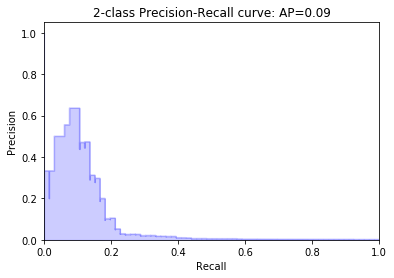

In [18]:
from sklearn.metrics import precision_recall_curve
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test_transformed, y_test_pred_proba)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

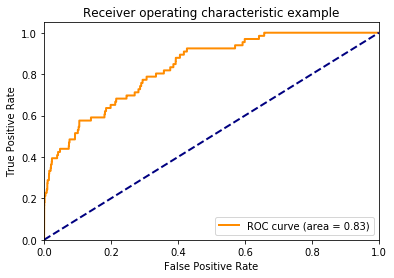

In [11]:
plt.figure()
lw = 2
roc_auc = roc_auc_score(y_test_transformed, y_test_pred_proba)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test_transformed, y_test_pred))

NameError: name 'y_test_pred' is not defined

### Code snippet for parameter optimization using cross-validation
#### These code doesn't belong to me, which you can find in the following page: 
#### https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py

### The following code is independent with the other part of this kaggle kernel
### If you want to run it or modify it according to your requirements, copy this snippet to your own computing device.

```python
import re
import logging
from time import time
from pprint import pprint
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import nltk as nlp
from nltk.corpus import stopwords

# IMPORTANT: Tweets Preprocessing
def pre_processing(t):
    HTTP_URL_PATTERN = r'((http|ftp|https):\/\/)?([\w-]+(?:(?:\.[\w-]{2,})+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'
    t = re.sub(HTTP_URL_PATTERN, '', t)
    t = re.sub('\s\W',' ',t)
    t = re.sub('\W,\s',' ',t)
    t = re.sub(r'\W', ' ', t)
    t = re.sub("\d+", " ", t)
    t = re.sub('\s+',' ',t)
    t = re.sub('[!@#$_]', ' ', t)
    t = t.lower()

    lemma = nlp.WordNetLemmatizer()
    stemmed_tweet = ""
    for word in t.split():
        stemmed_tweet += lemma.lemmatize(word)
        stemmed_tweet += " "
    return stemmed_tweet.strip()


# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


##############################################################################
TRAINSET_PATH = './modified.csv'
df = pd.read_csv(TRAINSET_PATH, encoding="utf-8")
print("DataFrame shape:")
print(df.shape)

# Cast the type of User_id field from int to string
df.user_id = df.user_id.apply(str)
# Pre-processing on tweets
df.tweet = df.tweet.apply(pre_processing)

# Set X and Y 
X = df.tweet.tolist()
Y = df.user_id

Y_transformed = Y.transform(lambda x: 1 if x == '4185' else 0)
print("%d tweets" % len(X))
print("%d categories" % len(Y_transformed.value_counts()))
print()

###############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
english_stopwords = set(stopwords.words('english'))
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False,
                              analyzer='word', stop_words=english_stopwords)),
    ('clf', LogisticRegression(solver='lbfgs')),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__max_features': (None, 5000, 10000),
    # 'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #     'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (200,),
    'clf__C': (0.01, 0.05, 0.1, 0.3, 0.5, 1.0),
    #     'clf__penalty': ('l2', 'l1'),
    'clf__class_weight': ({1: 30}, {1: 50}, {1: 100})
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, scoring='f1', cv=3,
                               n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X, Y_transformed)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
```

In [ ]:
# Train a classifier for multiple classes
# DON'T uncomment the following codes, it's really time-consuming as well as space-consuming.
# The performance of multiple class logistic regression without pruning is unpredictable.

# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression()
# clf.fit(x_train, y_train)

# from sklearn.metrics import accuracy_score
# y_test_pred = pd.Series(clf.predict(x_test))
# accuracy_score(y_test_transformed, y_test)

In [ ]:
### Abandoned Codes, to be removed

# # Feature Extraction using TF-IDF
# from sklearn.feature_extraction.text import TfidfVectorizer
# ALL_TWEETS = df.tweet.tolist()
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(ALL_TWEETS)
# # >>> print(X.shape)
# # Display All Feature(term) names
# # >>> print(vectorizer.get_feature_names()) 

# # Train a classfier for a specific user based on logstic regression
# from sklearn.model_selection import train_test_split
# x = X
# y = df.user_id
# RANDOM_SEED = int.from_bytes("Group95".encode(), 'little') % (2**32 - 1)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)

# y_train_transformed = y_train.transform(lambda x : 1 if x == '4185' else 0)
# y_test_transformed = y_test.transform(lambda x : 1 if x == '4185' else 0)

# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(C=.3, solver='lbfgs')
# clf.fit(x_train, y_train_transformed)

# from sklearn.metrics import accuracy_score
# y_test_pred = pd.Series(clf.predict(x_test))
# y_test_pred.value_counts()
# y_test_transformed.value_counts()
# # >>> accuracy_score(y_test_transformed, y_test_pred)


## The snippet below are used for multiclass categorization

```python
from sklearn.model_selection import train_test_split
x = X
y = df.user_id
RANDOM_SEED = int.from_bytes("Group95".encode(), 'little') % (2**32 - 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)
```

```python
# Set training granularity
SAMPLE_THRESHOLD = 30
CLASS_DISTRO = y_train.value_counts()
LABELS = CLASS_DISTRO[CLASS_DISTRO > SAMPLE_THRESHOLD].index
SAMPLE_AMOUNT = y_train.shape[0]
print("{} Classifiers to be trained".format(len(LABELS)))

classifier_dict = dict()
# Training multiple binary 1vALL logistic regression classifier
for label in LABELS:
    label = str(label)
    weight = math.sqrt(SAMPLE_AMOUNT / CLASS_DISTRO[label])
    y_train_transformed = y_train.transform(lambda x: 1 if x == label else 0)
    y_test_transformed = y_test.transform(lambda x: 1 if x == label else 0)

    clf = LogisticRegression(
        C=1, solver='lbfgs', max_iter=200, class_weight={1: weight})
    clf.fit(x_train, y_train_transformed)
    classifier_dict[label] = clf
    if (len(classifier_dict) % 10 == 0):
        print("{} Classifiers Trained!".format(len(classifier_dict)))
```

In [ ]:
# For test cases, find the most probable classification
y_pred = list()
for vector in x_test:
    prediction = '1'
    max_proba = 0
    for label, clf in classifier_dict:
        proba = clf.predict_proba(vector)[0][1]
        if proba > max_proba:
            max_proba = proba
            prediction = label

y_pred.append(prediction)

```python
output = pd.DataFrame({'Id': range(1, x_test.shape[0] + 1),
                       'Predicted': y_pred})
output.to_csv(index=False)
```